In [2]:
# import library
import re
import os 
import glob
import random
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, Nadam
from keras.applications import InceptionV3
from keras import callbacks

In [3]:
# define base path
base_path = '../dataset_final/train'

# check data classes
classes = os.listdir(base_path)
print(classes)

# count data
img_list = glob.glob(os.path.join(base_path, '*/*.jpg'))
print(len(img_list))

['paper', '.DS_Store', 'metal', 'cardboard', 'trash', 'glass', 'plastic']
6584


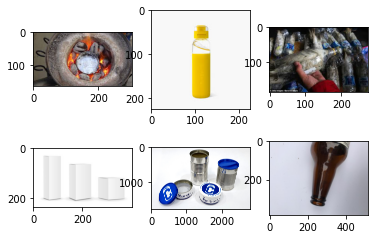

In [4]:
# plot some random image at random classes
for i, img_path in enumerate(random.sample(img_list, 6)):
    img = load_img(img_path)
    img = img_to_array(img, dtype=np.uint8)

    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

In [5]:
# use ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  rotation_range = 20,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=0.2)

train_generator = train_datagen.flow_from_directory(base_path,
                                                   target_size=(224,224),
                                                   batch_size=100,
                                                   class_mode='categorical',
                                                   subset='training',
                                                   seed=0)

validation_generator = train_datagen.flow_from_directory(base_path,
                                                       target_size=(224,224),
                                                       batch_size=100,
                                                       class_mode='categorical',
                                                       subset='validation',
                                                       seed=0)

labels = train_generator.class_indices
labels = dict((v, k) for k, v in labels.items())
print(labels)

Found 5269 images belonging to 6 classes.
Found 1315 images belonging to 6 classes.
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


In [5]:
# Use InceptionV3 transfer learning to set our model
base_model = InceptionV3(weights='imagenet', include_top = False, classifier_activation='softmax', input_shape=(224, 224, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu', kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
predictions = Dense(6, activation='softmax')(x)

# Freeze all layers except last 3 layer in the InceptionV3 base model
for layer in base_model.layers[:-3]:
    layer.trainable = False

# Define trainable model which links input from the  base model to the new classification prediction layers
model = Model(inputs=base_model.input, outputs=predictions)

# Define model compile for basic Transfer Learning
model.compile(optimizer=Nadam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

print (model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

activation_76 (Activation)      (None, 5, 5, 320)    0           batch_normalization_76[0][0]     
__________________________________________________________________________________________________
mixed9_0 (Concatenate)          (None, 5, 5, 768)    0           activation_78[0][0]              
                                                                 activation_79[0][0]              
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 5, 5, 768)    0           activation_82[0][0]              
                                                                 activation_83[0][0]              
__________________________________________________________________________________________________
activation_84 (Activation)      (None, 5, 5, 192)    0           batch_normalization_84[0][0]     
__________________________________________________________________________________________________
mixed9 (Co

In [6]:
# set early stop
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [7]:
# fit model
history = model.fit_generator(train_generator,
                             epochs=10,
                             validation_data=validation_generator,
                             callbacks = [early_stop],
                             verbose=1)


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
 8/53 [===>..........................] - ETA: 6:44 - loss: 8.6857 - accuracy: 0.2163

C:\Users\oillio\Anaconda3\lib\site-packages\PIL\Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


53/53 [==============================] - 657s 12s/step - loss: 2.1914 - accuracy: 0.5689 - val_loss: 1.0738 - val_accuracy: 0.6015
Epoch 2/10
53/53 [==============================] - 635s 12s/step - loss: 0.7805 - accuracy: 0.7181 - val_loss: 0.9649 - val_accuracy: 0.6669
Epoch 3/10
53/53 [==============================] - 632s 12s/step - loss: 0.7038 - accuracy: 0.7435 - val_loss: 0.8272 - val_accuracy: 0.6981
Epoch 4/10
53/53 [==============================] - 635s 12s/step - loss: 0.6687 - accuracy: 0.7595 - val_loss: 0.7717 - val_accuracy: 0.7057
Epoch 5/10
53/53 [==============================] - 633s 12s/step - loss: 0.6518 - accuracy: 0.7621 - val_loss: 0.7919 - val_accuracy: 0.7049
Epoch 6/10
53/53 [==============================] - 636s 12s/step - loss: 0.5876 - accuracy: 0.7891 - val_loss: 0.7546 - val_accuracy: 0.7293
Epoch 7/10
53/53 [==============================] - 631s 12s/step - loss: 0.5581 - accuracy: 0.7954 - val_loss: 0.7920 - val_accuracy: 0.7293
Epoch 8/10
53/53 

In [8]:
# save best model
model.save('InceptionV3.h5')
print('model saved')

model saved


In [9]:
# evaluate the model
score = model.evaluate_generator(validation_generator, verbose=1)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

Instructions for updating:
Please use Model.evaluate, which supports generators.
14/14 [==============================] - 107s 8s/step - loss: 0.7839 - accuracy: 0.7323
Test loss:  0.7838514447212219
Test accuracy:  0.7323194146156311


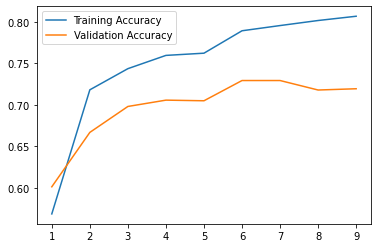

In [10]:
# plot data to see relationships in training and validation data
epoch_list = list(range(1, len(history.history['accuracy']) + 1))
plt.plot(epoch_list, history.history['accuracy'], epoch_list, history.history['val_accuracy'])
plt.legend(('Training Accuracy', 'Validation Accuracy'))
plt.show()

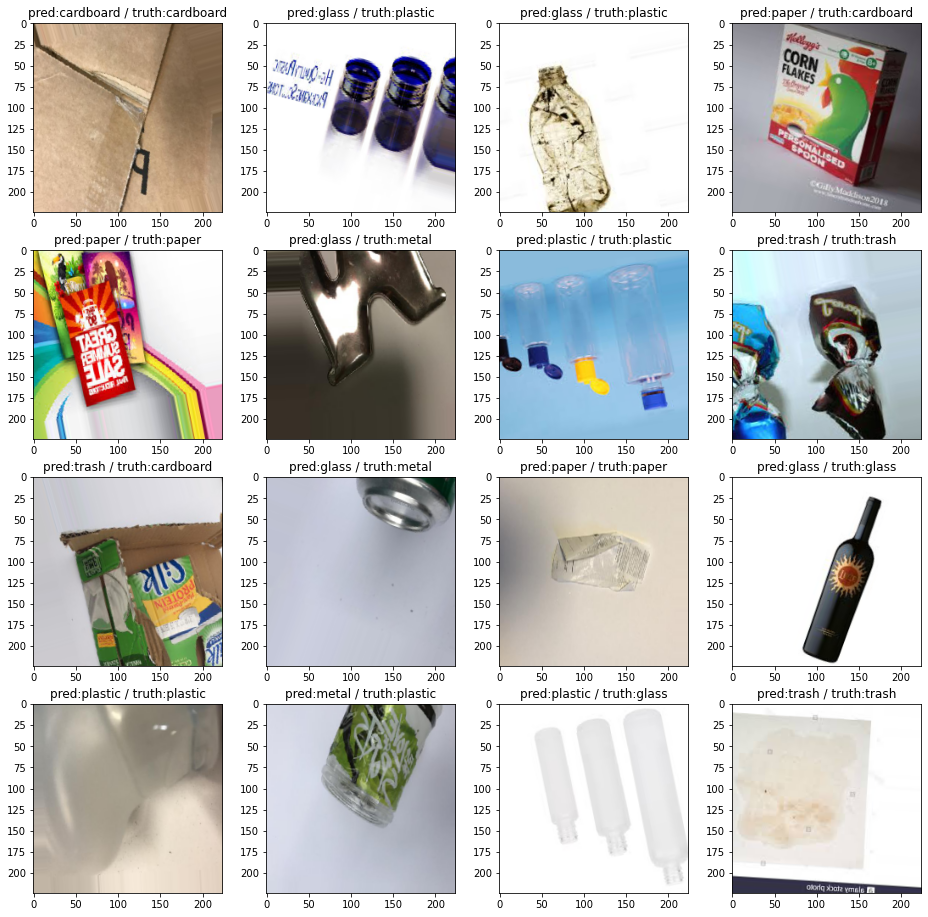

In [11]:
X_test, y_test = validation_generator.__getitem__(1)

preds = model.predict(X_test)

plt.figure(figsize=(16, 16))
# Use 16 image make prediction
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(y_test[i])]))
    plt.imshow(X_test[i])